In [2]:


from __future__ import division
import os
import sys
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as st

%matplotlib inline
%precision 4
plt.style.use('ggplot')


In [3]:
from mpl_toolkits.mplot3d import Axes3D
import scipy.stats as stats
from functools import partial


## Bayesian Data Analysis

The fundamental objective of Bayesian data analysis is to determine the posterior distribution of the parameters $\theta $ based on a measured data set $X$

$$ p(\theta |X) = \frac{p(X | \theta) p(\theta)}{p(X)}$$

where the denominator is the so-called evidence, which is an integral of the posterior probability over all possible parameters

$$ p(X) = \int d \theta^* p(X | \theta^*) p(\theta^*) $$

Here,
* $p(\theta |X)$ is the likelihood,
* $p(\theta)$ is the prior and
* $p(X)$ is a normalizing constant also known as the evidence or marginal likelihood

The computational issue is the difficulty of evaluating the integral in the denominator. There are many ways to address this difficulty, inlcuding:

*    In cases with conjugate priors (with conjugate priors, the posterior has the same distribution as the prior), we can get closed form solutions
*    We can use numerical integration
*    We can approximate the functions used to calculate the posterior with simpler functions and show that the resulting approximate posterior is “close” to true posteiror (variational Bayes)
*    We can use Monte Carlo methods, of which the most important is Markov Chain Monte Carlo (MCMC)


## Motivating example

We will use the toy example of estimating the bias of a coin given a sample consisting of n tosses to illustrate a few of the approaches.

### Analytical solution

If we use a beta distribution as the prior, then the posterior distribution has a closed form solution. This is shown in the example below. Some general points:

*    We need to choose a prior distribtution family (i.e. the beta here) as well as its parameters (here a=10, b=10)
*        The prior distribution may be relatively uninformative (i.e. more flat) or informative (i.e. more peaked)
* The posterior depends on both the prior and the data
    * As the amount of data becomes large, the posterior approximates the MLE
    * An informative prior takes more data to shift than an uninformative one
*    Of course, it is also important the model used (i.e. the likelihood) is appropriate for the fitting the data
*    The mode of the posterior distribution is known as the maximum a posteriori (MAP) estimate (cf MLE which is the mode of the likelihood)


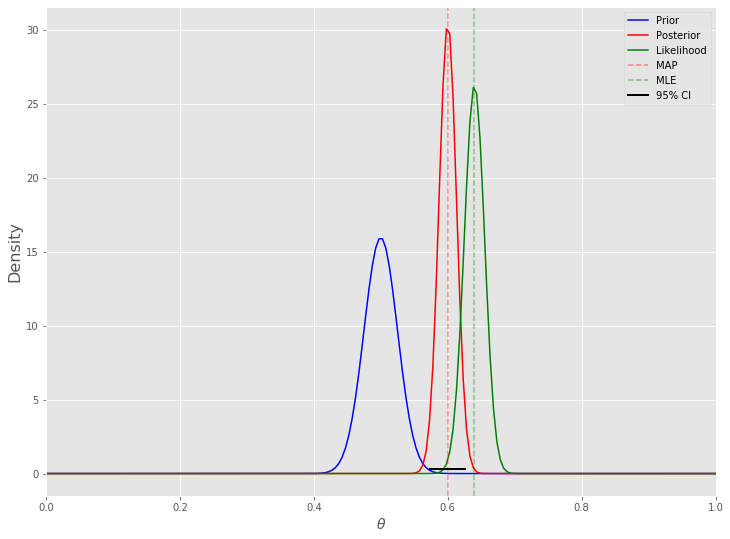

In [14]:
n = 1000
#h = 500
h = 640  #hertz
p = h/n
rv = st.binom(n, p)
mu = rv.mean()

a, b = 200, 200
prior = st.beta(a, b)
post = st.beta(h+a, n-h+b)
ci = post.interval(0.95)

thetas = np.linspace(0, 1, 200)
plt.figure(figsize=(12, 9))
plt.style.use('ggplot')
plt.plot(thetas, prior.pdf(thetas), label='Prior', c='blue')
plt.plot(thetas, post.pdf(thetas), label='Posterior', c='red')
plt.plot(thetas, n*st.binom(n, thetas).pmf(h), label='Likelihood', c='green')
plt.axvline((h+a-1)/(n+a+b-2), c='red', linestyle='dashed', alpha=0.4, label='MAP')
plt.axvline(mu/n, c='green', linestyle='dashed', alpha=0.4, label='MLE')
plt.xlim([0, 1])
plt.axhline(0.3, ci[0], ci[1], c='black', linewidth=2, label='95% CI');
plt.xlabel(r'$\theta$', fontsize=14)
plt.ylabel('Density', fontsize=16)
plt.legend();

## MCMC

This lecture will only cover the basic ideas of MCMC in the most common variant - Metropolis-Hastings. All code will be built from the ground up to ilustrate what is involved in fitting an MCMC model, but only toy examples will be shown since the goal is conceptual understanding. 

In Bayesian statistics, we want to estiamte the posterior distribution, but this is often intractable due to the high-dimensional integral in the denominator (marginal likelihood). A few other ideas we have encountered that are also relevant here are Monte Carlo integration with inddependent samples and the use of proposal distributions (e.g. rejection and importance sampling). As we have seen from the Monte Carlo inttegration lectures, we can approximate the posterior $p(\theta|X)$ if we can somehow draw many samples that come from the posterior distribution. With vanilla Monte Carlo integration, we need the samples to be independent draws from the posterior distribution, which is a problem if we do not actually know what the posterior distribution is .

With MCMC, we draw samples from a (simple) proposal distribution so that each draw depends only on the state of the previous draw (i.e. the samples form a Markov chain). Under certain condiitons, the Markov chain will have a unique stationary distribution. In addition, not all samples are used - instead we set up acceptance criteria for each draw based on comparing successive states with respect to a target distribution that enusre that the stationary distribution is the posterior distribution of interest. The nice thing is that this target distribution only needs to be proportional to the posterior distribution, which means we don’t need to evaluate the potentially intractable marginal likelihood, which is just a normalizing constant. We can find such a target distribution easily, since $posterior \propto likelihood \times prior$. After some time, the Markov chain of accepted draws will converge to the staionary distribution, and we can use those samples as (correlated) draws from the posterior distribution, and find functions of the posterior distribution in the same way as for vanilla Monte Carlo integration.

There are several flavors of MCMC, but the simplest to understand is the Metropolis-Hastings random walk algorithm, and we will start there.

To carry out the Metropolis-Hastings algorithm, we need to draw random samples from the folllowing distributions

* the standard uniform distribution
* a proposal distriution $p(x)$ that we choose to be $\mathcal N (0,\sigma)$
* the target distribution $g(x)$ which is proportional to the posterior probability

Given an initial guess for $\theta$ with positive probability of being drawn, the Metropolis-Hastings algorithm proceeds as follows

* Choose a new proposed value $\theta_p$ such that $\theta_p =\theta+ \Delta \theta$ where $\Delta \theta \sim \mathcal N (0,\sigma)$

* Caluculate the ratio
$$\rho = \frac{g (\theta_p |X))}{g (\theta |X)}$$

where $g$ is the posterior probability.

* If the proposal distribution is not symmetrical, we need to weight the accceptanc probablity to maintain detailed balance (reversibilty) of the stationary distribution, and instead calculate

$$\rho = \frac{g (\theta_p |X)) \, p(\theta | \theta_p)}{g (\theta |X) \, p(\theta)}$$

* If $\rho \ge 1$ then set $\theta=\theta_p$

* If $\rho < 1$, then set $\theta=\theta_p$ with probability $\rho$, otherwise set $\theta=\theta$ (this is where we use the standard uniform distribution)

* Repeat the earlier steps

After some number of iterations k, the samples $\theta_{k+1},\theta_{k+2},…$ will be samples from the posterior distributions. Here are initial concepts to help your intuition about why this is so:

* We accept a proposed move to $\theta_{k+1}$ whenever the density of the (unnormalzied) target distribution at $\theta_{k+1}$ is larger than the value of $\theta_k$ - so $\theta$ will more often be found in places where the target distribution is denser
* If this was all we accepted, $\theta$ would get stuck at a local mode of the target distribution, so we also accept occasional moves to lower density regions - it turns out that the correct probability of doing so is given by the ratio $\rho$
* The acceptance criteria only looks at ratios of the target distribution, so the denominator cancels out and does not matter - that is why we only need samples from a distribution proprotional to the posterior distribution
* So, $\theta$ will be expected to bounce around in such a way that its spends its time in places proportional to the density of the posterior distribution - that is, $\theta$ is a draw from the posterior distribution.

Additional notes:

Different propsoal distributions can be used for Metropolis-Hastings:
* The independence sampler uses a proposal distribtuion that is independent of the current value of $\theta$. In this case the propsoal distribution needs to be similar to the posterior distirbution for efficiency, while ensuring that the acceptance ratio is bounded in the tail region of the posterior.
* The random walk sampler (used in this example) takes a random step centered at the current value of $\theta$ - efficiency is a trade-off between small step size with high probability of acceptance and large step sizes with low probaiity of acceptance. Note  that the random walk may take a long time to traverse narrow regions of the probabilty distribution. Changing the step size (e.g. scaling $\Sigma$ for a multivariate normal proposal distribution) so that a target proportion of proposals are accepted is known as tuning.
* Much research is being conducted on different proposal distributions for efficient sampling of the posterior distribution.

We will first see a numerical example and then try to understand why it works.

In [44]:
def target(lik, prior, n, h, theta):
    if theta < 0 or theta > 1:
        return 0
    else:
        return lik(n, theta).pmf(h)*prior.pdf(theta)

n = 1000
h = 610 
a = 5
b = 5
lik = st.binom
prior = st.beta(a, b)
sigma = 0.5 # width of the proposal distribution, determines the step-size

naccept = 0
theta = 0.5 # starting value of the chain
niters = 1000
samples = np.zeros(niters+1)
samples[0] = theta
for i in range(niters):
    theta_p = theta + st.norm(0, sigma).rvs()
    rho = min(1, target(lik, prior, n, h, theta_p)/target(lik, prior, n, h, theta ))
    u = np.random.uniform()
    if u < rho:
        naccept += 1
        theta = theta_p
    samples[i+1] = theta
nmcmc = len(samples)//2
print "Efficiency = ", naccept/niters


Efficiency =  0.037


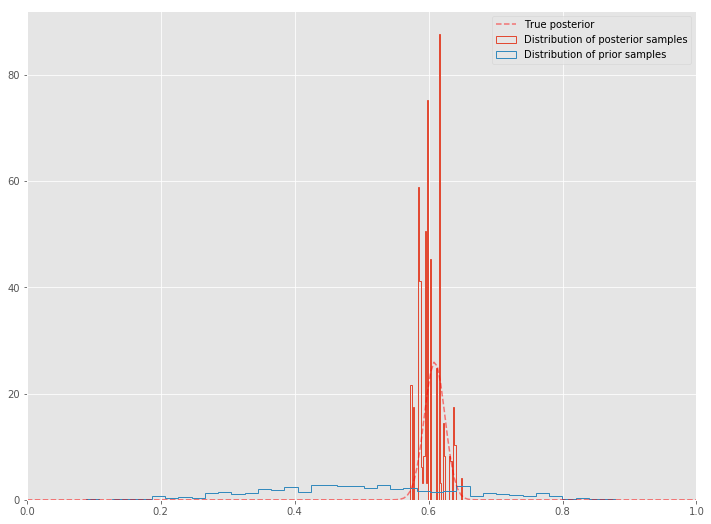

In [45]:
post = st.beta(h+a, n-h+b)

plt.figure(figsize=(12, 9))
plt.hist(samples[nmcmc:], 40, histtype='step', normed=True, linewidth=1, label='Distribution of posterior samples');
plt.hist(prior.rvs(nmcmc), 40, histtype='step', normed=True, linewidth=1, label='Distribution of prior samples');
plt.plot(thetas, post.pdf(thetas), c='red', linestyle='--', alpha=0.5, label='True posterior')
plt.xlim([0,1]);
plt.legend(loc='best');

### Exercises:

1) Change the values for the prior distribution (a, b) and for the outcome of the experiment h. Explain qualitatively how the true posterior shifts.

2) Create a situation where the "distribution of the posterior samples" does not recover the "true posterior"

3) Create a situation where the efficiency is extremely low, but the results (distribution of posterior matching the true posterior) are still very good.

Trace plots are often used to informally assess for stochastic convergence. Rigorous demonstration of convergence is an unsolved problem, but simple ideas such as running mutliple chains and checking that they are converging to similar distribtions are often employed in practice.

In [46]:
def mh_coin(niters, n, h, theta, lik, prior, sigma):
    samples = [theta]
    while len(samples) < niters:
        theta_p = theta + st.norm(0, sigma).rvs()
        rho = min(1, target(lik, prior, n, h, theta_p)/target(lik, prior, n, h, theta ))
        u = np.random.uniform()
        if u < rho:
            theta = theta_p
        samples.append(theta)
    return samples

In [47]:
n = 100
h = 61
lik = st.binom
prior = st.beta(a, b)
sigma = 0.05
niters = 100

sampless = [mh_coin(niters, n, h, theta, lik, prior, sigma) for theta in np.arange(0.1, 1, 0.2)]


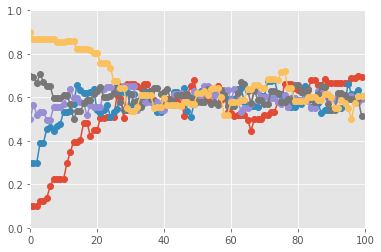

In [48]:
# Convergence of multiple chains

for samples in sampless:
    plt.plot(samples, '-o')
plt.xlim([0, niters])
plt.ylim([0, 1]);

There are two main ideas - first that the samples generated by MCMC constitute a Markov chain, and that this Markov chain has a unique stationary distribution that is always reached if we generate a very large number of samples. The second idea is to show that this stationary distribution is exactly the posterior distribution that we are looking for. 

### Exercises:
1) Explain the Figure above. What is shown on the axes? What is the behavior at the beginning? 

2) How does the Figure change when changing sigma and/or niters?